# Evaluation for Classification hw04

## Dataset

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

We need to take `bank/bank-full.csv` file from the downloaded zip-file.
In this dataset our desired target for classification task will be `y` variable - has the client subscribed a term deposit or not.

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('bank-full.csv', sep=';')
df.shape

(45211, 17)

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Features

For the rest of the homework, we'll need to use only these columns:

* `age`,
* `job`,
* `marital`,
* `education`,
* `balance`,
* `housing`,
* `contact`,
* `day`,
* `month`,
* `duration`,
* `campaign`,
* `pdays`,
* `previous`,
* `poutcome`,
* `y`

## Data preparation

- Select only the features from above.
- Check if the missing values are presented in the features.

In [5]:
features = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 
    'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]

In [6]:
df = df[features]

In [7]:
df.y = (df.y == 'yes').astype(int) # target encoding

In [8]:
#Preparing the dataset
cat = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

num = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

## Split the data

* Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [9]:
#Spliting the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [12]:
df_train = df_train.drop('y', axis=1)
df_val = df_val.drop('y', axis=1)
df_test = df_test.drop('y', axis=1)

In [13]:
y_train, y_val, y_test

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 1]))

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `balance`
* `day`
* `duration`
* `previous`

In [14]:
#Calculating ROC AUC Score:
for c in num:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

      age, 0.512
  balance, 0.589
      day, 0.526
 duration, 0.815
 campaign, 0.571
    pdays, 0.590
 previous, 0.599


**Answer =** `duration`

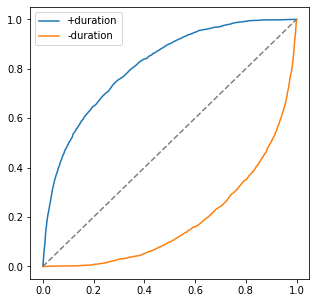

In [15]:
#Plotting the ROC curve for duration
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.duration)
plt.plot(fpr, tpr, label='+duration')

fpr, tpr, _ = roc_curve(y_train, -df_train.duration)
plt.plot(fpr, tpr, label='-duration')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

We can see that there's separation in distribution of duration between positive and negative classes (this is what AUC tells us about)

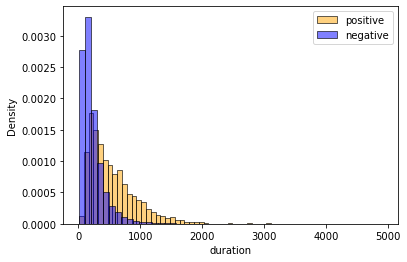

In [16]:
sns.histplot(df_train.duration[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.duration[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

For negative examples (blue) the values of duration tend to be higher. That's why AUC is below 0.5 - the correlation is negative.

If we revese the order by negating the values of duration, the positive examples will tend to have higher values than negative. That's why AUC of "-duration" is above 0.5

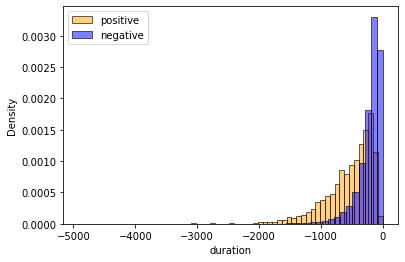

In [17]:
sns.histplot(-df_train.duration[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(-df_train.duration[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.69
* 0.79
* 0.89
* 0.99

In [18]:
#Training the Logistic Regression model:
columns = cat + num

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [19]:
#Inspecting ROC_AUC Score:
round(roc_auc_score(y_val, y_pred), 3)

0.9

**Answer =** `0.900`

Let's compare it with the output of `predict`:

In [20]:
y_pred_bin = model.predict(X_val)
round(roc_auc_score(y_val, y_pred_bin), 3)

0.657

This is incorrect. Let's look at the ROC curves:

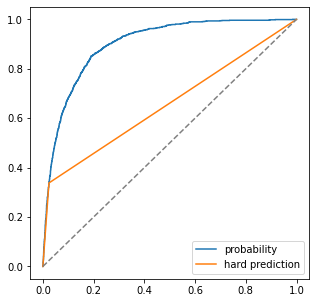

In [21]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [22]:
#Creating a Confusion matrix
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [23]:
#Implementation
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1098,7944,0,0
10,0.1,927,1494,171,6450
20,0.2,709,697,389,7247
30,0.3,568,413,530,7531
40,0.4,463,275,635,7669
50,0.5,371,190,727,7754
60,0.6,291,137,807,7807
70,0.7,225,102,873,7842
80,0.8,149,66,949,7878
90,0.9,76,28,1022,7916


In [24]:
#Adding precision and recall columns
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

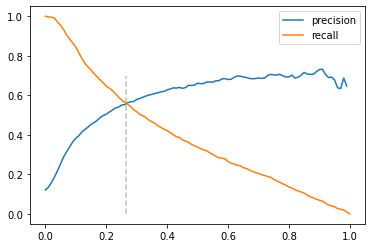

In [25]:
#Inspecting the curves
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')
plt.vlines(0.265, 0, 0.7, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

**Answer =**`0.265`.

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.02
* 0.22
* 0.42
* 0.62

In [26]:
#Getting F1 scores
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

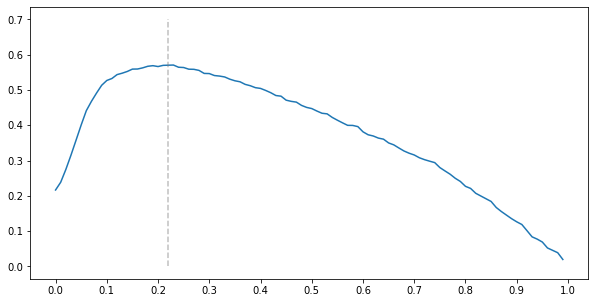

In [27]:
#Inspecting F1 scores
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.22, 0, 0.7, color='grey', linestyle='--', alpha=0.5)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

**Answer =** `0.22`

## Question 5: CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`
* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.26

In [28]:
#Defining train and predict functions
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [29]:
#Inspecting KFold cross validation
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


**Answer:** `0.006` 

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [30]:
#Inspecting KFold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%5s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=    1, 0.906 +- 0.006


**Answer =** `1`